<a href="https://colab.research.google.com/github/ddwooten/NE255/blob/master/emotion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [0]:

import cv2
import tarfile
import zipfile
import os
import copy
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


In [68]:
#mount my google drive folder and set the working dir to the google drive folder that has the unzipped kaggle data folder downloaded from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data 
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

#change this if you saved it somewhere else.
#working_dir = '/content/drive/My Drive/Projects_Ongoing/classes_and_workshops/GDSO_Workshop_2019/emotion_project/challenges-in-representation-learning-facial-expression-recognition-challenge/'
working_dir = '/content/drive/My Drive/ml_workgroup_2019_drive/'
# working_dir = '/content/drive/My Drive/GDSO_Workshop_2019/' # Mandy's drive directory

Mounted at /content/drive/


In [0]:
#extract the tar file
tar_dir = tarfile.open(working_dir + 'fer2013.tar.gz', 'r:gz')
tar_dir.extractall(working_dir)

# Running gitshanks's model from scratch

https://github.com/gitshanks/fer2013?source=post_page---------------------------

https://medium.com/themlblog/how-to-do-facial-emotion-recognition-using-a-cnn-b7bbae79cd8f

## Preprocessing

In [69]:
#dataset from kaggle challege read into a pandas dataframe
images_df = pd.read_csv(working_dir + 'fer2013/fer2013.csv')
#There may be a problem with ascii encoding on the original csv
#This version has been converted to UTF-8
images_df = pd.read_csv(working_dir + 'fer2013/ufer2013.csv')

images_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [70]:
#make a emotion dict that relates the emotion number with the expression
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}
#see some descriptive statistics
images_df['emotion'].value_counts().rename(emotion_dict)

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: emotion, dtype: int64

In [0]:
#Setting up the training data
train_df = images_df[images_df['Usage'] == 'Training'][['emotion', 'pixels']]
train_df['pixels'] = train_df['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
# Nice work Susan! How did you come up with this method, its the elegence I've
# been trying to get for hours!
index_0s = [i for i, x in enumerate(train_df['pixels']) if np.sum(x) == 0]

In [0]:
#df without 0s.
train_df = train_df[~train_df.index.isin(index_0s)].reset_index(drop = True)

In [73]:
x_train = np.vstack(train_df['pixels'].values)
y_train = np.array(train_df['emotion'])
print ('x_train shape is: ', x_train.shape)
print ('y_train shape is: ', y_train.shape)

x_train shape is:  (28698, 2304)
y_train shape is:  (28698,)


In [85]:
#Setting up the public test data
public_test_df = images_df[images_df['Usage'] == 'PublicTest'][['emotion', 'pixels']]
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
index2_0s = [i for i, x in enumerate(public_test_df['pixels']) if np.sum(x) == 0]
public_test_df = public_test_df[~public_test_df.index.isin(index2_0s)].reset_index(drop = True)
x_public_test = np.vstack(public_test_df['pixels'].values)
y_public_test = np.array(public_test_df['emotion'])
print('x_public_test shape is: ', x_public_test.shape)
print('y_public_test shape is: ', y_public_test.shape)

x_public_test shape is:  (3589, 2304)
y_public_test shape is:  (3589,)


In [75]:
#resahpe images to a 48 x 48 pixel matrix
x_train = x_train.reshape(-1, 48, 48)
x_public_test = x_public_test.reshape(-1, 48, 48)
print ('x_train new shape is: ', x_train.shape)
print ('x_test new shape is: ', x_public_test.shape)

x_train new shape is:  (28698, 48, 48)
x_test new shape is:  (3589, 48, 48)


In [76]:
#Make y categorical
y_train_cat= pd.get_dummies(y_train).as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


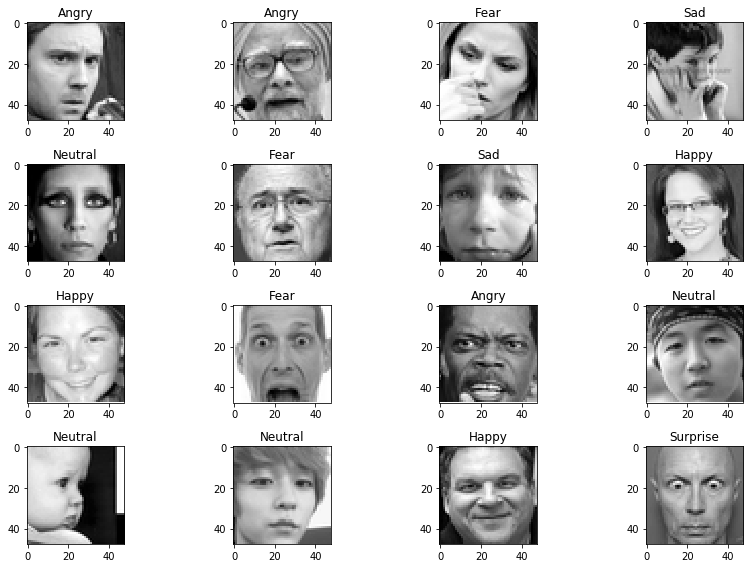

In [77]:
#show some images
plt.figure(0, figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(x_train[i, :, :], cmap='gray')
  plt.title(emotion_dict[np.where(y_train_cat[i] == 1)[0][0]])
plt.tight_layout()
plt.show()

# Model Testing (SH)
Might still need to z score x data but not sure

In [0]:
#setting up the parameters
num_features = 64


In [0]:
model_sh = Sequential()
model_sh.add(Conv2D(num_features, kernel_size = (3, 3), activation = 'relu', 
                   input_shape = (48, 48, 1), data_format = "channels_last", 
                   kernel_regularizer = l2(0.01)))

(28698, 48)

# **Model Testing**

In [106]:

# We must use the non-reshaped versions of the data, as this is what fit()
# expects

x_raw = train_df['pixels']
y_raw = train_df['emotion']

x_data = np.vstack(train_df['pixels'].values)
y_data = np.array(y_raw)

# The y_data needs to be catagorical
from keras.utils.np_utils import to_categorical
y_data = to_categorical(y_data, num_classes=7)
#y_data = pd.get_dummies(y_data).as_matrix()

print('The type of x_data is:' + str(type(x_data)))
print('The shape of x_data is:' + str(len(x_data)))
print('The type of x_data[1] is:' + str(type(x_data[1])))
print('The shape of x_data[1] is:' + str(x_data[1].shape[0]))
print('The type of y_data is:' + str(type(y_data)))
print('The shape of y_data is:' + str(len(y_data)))
print('The type of y_data[1] is:' + str(type(y_data[1])))
print('Catagorical y_data looks like:' + str(y_data[1]))

The type of x_data is:<class 'numpy.ndarray'>
The shape of x_data is:28698
The type of x_data[1] is:<class 'numpy.ndarray'>
The shape of x_data[1] is:2304
The type of y_data is:<class 'numpy.ndarray'>
The shape of y_data is:28698
The type of y_data[1] is:<class 'numpy.ndarray'>
Catagorical y_data looks like:[1. 0. 0. 0. 0. 0. 0.]


In [0]:
# Set up a basic, multi-layered [ 1 input, 1 output, n hidden layers ]
# feedforward neural net. Train it on the data, see how it does, compare
# with other similar models made in this section. The parameters to vary
# are the number of neurons per layer, the number of hidden layers,
# and the activation function, the loss functin, and
# the optimizer, roughly.

# Here we instantiate model 1

from keras.models import Sequential
from keras.layers import Dense

model_1 = Sequential()

neurons = 10

# When the first output or hidden layer is created in the model, the
# input layer is as well. We begin with the relu activaion function
# as this is current industry best practices according to various
# blogs. model_1 has one input layer with nuerons equal to the number of pixels.
# There is one hidden layer of 10 neurons and 1 ouput layer.

model_1.add(Dense(neurons*10, activation='relu', input_shape = (x_data[1].shape[0],)))
model_1.add(Dense(neurons, activation='relu'))
model_1.add(Dense(7))
model_1.summary()

In [0]:
# To prepre model_1 for testing it needs to be compiled with an optimizer and
# a loss function. For the optimizer we begin with sgd, a common choice on
# blogs. For the loss function we begin with the mean-squared-error, another
# common blog choice.

model_1.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
# This next step is a clever move from this blog...
# https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37
# We engage an early stopping criteria for all keras trainig loops

from keras.callbacks import EarlyStopping

# Setting patience to 3 indicates that after 3 iterations (epochs) without model
# imporvement the training loops will terminate early
early_stop = EarlyStopping(patience=3)


In [110]:
# Here the magic happens, we train our very first model by calling fit()

model_1.fit(x_data,y_data, validation_split=0.2, epochs=200, callbacks=[early_stop])

Train on 22958 samples, validate on 5740 samples
Epoch 1/200
22958/22958 [==============================] - 5s 221us/step - loss: 449.2019 - val_loss: 0.5081
Epoch 2/200
22958/22958 [==============================] - 4s 193us/step - loss: 0.3476 - val_loss: 0.3315
Epoch 3/200
22958/22958 [==============================] - 4s 188us/step - loss: 0.2356 - val_loss: 0.2768
Epoch 4/200
22958/22958 [==============================] - 4s 193us/step - loss: 0.1825 - val_loss: 0.2472
Epoch 5/200
22958/22958 [==============================] - 4s 194us/step - loss: 0.1554 - val_loss: 0.2356
Epoch 6/200
22958/22958 [==============================] - 4s 189us/step - loss: 0.1374 - val_loss: 0.2246
Epoch 7/200
22958/22958 [==============================] - 4s 190us/step - loss: 0.1281 - val_loss: 0.2159
Epoch 8/200
22958/22958 [==============================] - 4s 189us/step - loss: 0.1234 - val_loss: 0.2108
Epoch 9/200
22958/22958 [==============================] - 4s 186us/step - loss: 0.1214 - val

In [0]:
pred_1 = model_1.predict(x_public_test)

In [111]:
y_test = to_categorical(y_public_test, num_classes=7)
print(y_test[1])

[0. 1. 0. 0. 0. 0. 0.]


In [124]:
mse_1 = np.sum((y_test - pred_1) * (y_test - pred_1))/y_test.shape[0]

1.3019948105321817

In [126]:
model_2 = Sequential()

neurons = 10

# When the first output or hidden layer is created in the model, the
# input layer is as well. We begin with the relu activaion function
# as this is current industry best practices according to various
# blogs. model_1 has one input layer with nuerons equal to the number of pixels.
# There is one hidden layer of 10 neurons and 1 ouput layer.

model_2.add(Dense(1152, activation='relu', input_shape = (x_data[1].shape[0],)))
model_2.add(Dense(48, activation='relu'))
model_2.add(Dense(7))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1152)              2655360   
_________________________________________________________________
dense_32 (Dense)             (None, 48)                55344     
_________________________________________________________________
dense_33 (Dense)             (None, 7)                 343       
Total params: 2,711,047
Trainable params: 2,711,047
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [128]:
model_2.fit(x_data,y_data, validation_split=0.2, epochs=200, callbacks=[early_stop])

Train on 22958 samples, validate on 5740 samples
Epoch 1/200
22958/22958 [==============================] - 34s 1ms/step - loss: 574.2322 - val_loss: 0.1410
Epoch 2/200
22958/22958 [==============================] - 33s 1ms/step - loss: 0.1398 - val_loss: 0.1384
Epoch 3/200
22958/22958 [==============================] - 33s 1ms/step - loss: 0.1367 - val_loss: 0.1349
Epoch 4/200
22958/22958 [==============================] - 33s 1ms/step - loss: 0.1330 - val_loss: 0.1310
Epoch 5/200
22958/22958 [==============================] - 33s 1ms/step - loss: 0.1291 - val_loss: 0.1272
Epoch 6/200
22958/22958 [==============================] - 33s 1ms/step - loss: 0.1255 - val_loss: 0.1239
Epoch 7/200
22958/22958 [==============================] - 33s 1ms/step - loss: 0.1225 - val_loss: 0.1213
Epoch 8/200
22958/22958 [==============================] - 33s 1ms/step - loss: 0.1203 - val_loss: 0.1195
Epoch 9/200
22958/22958 [==============================] - 33s 1ms/step - loss: 0.1190 - val_loss: 0.

In [0]:
pred_2 = model_2.predict(x_public_test)

In [0]:
mse_2 = np.sum((y_test - pred_2) * (y_test - pred_2))/y_test.shape[0]

In [133]:
mse_2

0.826840421687796

In [134]:
model_3 = Sequential()

neurons = 10

# When the first output or hidden layer is created in the model, the
# input layer is as well. We begin with the relu activaion function
# as this is current industry best practices according to various
# blogs. model_1 has one input layer with nuerons equal to the number of pixels.
# There is one hidden layer of 10 neurons and 1 ouput layer.

model_3.add(Dense(1152, activation='relu', input_shape = (x_data[1].shape[0],)))
model_3.add(Dense(576, activation='relu'))
model_3.add(Dense(48, activation='relu'))
model_3.add(Dense(7))
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 1152)              2655360   
_________________________________________________________________
dense_35 (Dense)             (None, 576)               664128    
_________________________________________________________________
dense_36 (Dense)             (None, 48)                27696     
_________________________________________________________________
dense_37 (Dense)             (None, 7)                 343       
Total params: 3,347,527
Trainable params: 3,347,527
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_3.compile(optimizer='adam', loss='mean_squared_error')

In [136]:
model_3.fit(x_data,y_data, validation_split=0.2, epochs=200, callbacks=[early_stop])

Train on 22958 samples, validate on 5740 samples
Epoch 1/200
22958/22958 [==============================] - 48s 2ms/step - loss: 347.7173 - val_loss: 0.1404
Epoch 2/200
22958/22958 [==============================] - 47s 2ms/step - loss: 0.1384 - val_loss: 0.1362
Epoch 3/200
22958/22958 [==============================] - 47s 2ms/step - loss: 0.1338 - val_loss: 0.1313
Epoch 4/200
22958/22958 [==============================] - 47s 2ms/step - loss: 0.1287 - val_loss: 0.1264
Epoch 5/200
22958/22958 [==============================] - 47s 2ms/step - loss: 0.1242 - val_loss: 0.1224
Epoch 6/200
22958/22958 [==============================] - 47s 2ms/step - loss: 0.1210 - val_loss: 0.1199
Epoch 7/200
22958/22958 [==============================] - 47s 2ms/step - loss: 0.1191 - val_loss: 0.1186
Epoch 8/200
22958/22958 [==============================] - 47s 2ms/step - loss: 0.1183 - val_loss: 0.1182
Epoch 9/200
22958/22958 [==============================] - 48s 2ms/step - loss: 0.1181 - val_loss: 0.

In [0]:
pred_2 = model_2.predict(x_public_test)

In [0]:
mse_2 = np.sum((y_test - pred_2) * (y_test - pred_2))/y_test.shape[0]

In [0]:
mse_2

0.826840421687796